In [11]:
import os
import tempfile

import matplotlib.pyplot as plt
import scanpy as sc
import scvi
import torch
import skmisc
import anndata
import numpy as np
scvi.settings.seed = 0
import pandas as pd
import decoupler as dc

import time

Global seed set to 0


In [12]:
import pydeseq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats


# Load Shen et al. alignments


In [2]:
import tqdm

In [3]:
samples = ['GSM7336852_Day1',
           'GSM7336853_Day2',
           'GSM7336854_Day4',
           'GSM7336855_Day6']
rootdir = '/home/gennady/curation-results/cao'

In [4]:
ads = []
for sample in tqdm.tqdm(samples):
    ad=sc.read_10x_mtx(path=rootdir,prefix=sample+'_',gex_only=False)
    ads.append(ad)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:27<00:00,  6.90s/it]


In [5]:
knees = []
for ad in ads:
    knee = np.sort((np.array(ad.X.sum(axis=1))).flatten())[::-1]
    knees.append(knee)


Text(0, 0.5, 'UMI counts')

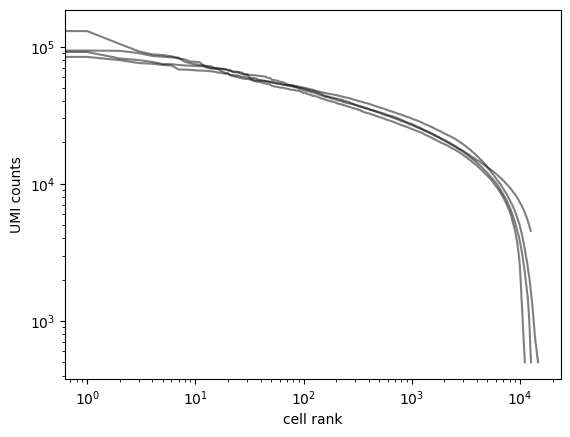

In [6]:
for i in range(len(ads)):
    plt.plot(range(len(knees[i])),knees[i],color='k',alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('cell rank')
plt.ylabel('UMI counts')


In [7]:

for gene in ['Xist','Uty','Zfy1','Zfy2','Ddx3y','Sry','Kdm5d','Kdm5c','Plp1']:
    print(gene)
    for i in range(4):
        print(int(ads[i][:,gene].X.sum()),end='\t')
    print()


Xist
43841	79850	53940	148583	
Uty
1601	288	582	1	
Zfy1
0	0	0	0	
Zfy2
0	0	0	0	
Ddx3y
4727	967	3191	2	
Sry
0	0	0	0	
Kdm5d
1198	256	558	4	
Kdm5c
4318	4351	3248	5397	
Plp1
856	465	484	805	


In [8]:

for gene in ['Xist','Uty','Zfy1','Zfy2','Ddx3y','Sry','Kdm5d','Kdm5c','Plp1']:
    print(gene)
    for i in range(4):
        print(np.round(ads[i][:,gene].X.mean(),3),end='\t')
    print()


Xist
2.986	6.324	4.868	11.827	
Uty
0.109	0.023	0.053	0.0	
Zfy1
0.0	0.0	0.0	0.0	
Zfy2
0.0	0.0	0.0	0.0	
Ddx3y
0.322	0.077	0.288	0.0	
Sry
0.0	0.0	0.0	0.0	
Kdm5d
0.082	0.02	0.05	0.0	
Kdm5c
0.294	0.345	0.293	0.43	
Plp1
0.058	0.037	0.044	0.064	


In [9]:

for gene in ['Xist','Uty','Zfy1','Zfy2','Ddx3y','Sry','Kdm5d','Kdm5c','Plp1']:
    print(gene)
    for i in range(4):
        cf = (ads[i][:,'Plp1'].X>0).toarray() | (ads[i][:,'Gfra3'].X>0).toarray() | (ads[i][:,'Kcna1'].X>0).toarray()
        print(np.round(ads[i][cf,gene].X.mean(),3),end='\t')
    print()
for i in range(4):
    cf = (ads[i][:,'Plp1'].X>0).toarray() | (ads[i][:,'Gfra3'].X>0).toarray() | (ads[i][:,'Kcna1'].X>0).toarray()
    print(cf.sum())

Xist
5.414	10.3	9.412	14.882	
Uty
0.176	0.059	0.103	0.0	
Zfy1
0.0	0.0	0.0	0.0	
Zfy2
0.0	0.0	0.0	0.0	
Ddx3y
0.577	0.142	0.333	0.0	
Sry
0.0	0.0	0.0	0.0	
Kdm5d
0.151	0.026	0.074	0.0	
Kdm5c
0.524	0.551	0.657	0.625	
Plp1
1.959	1.535	2.373	2.268	
437
303
204
355


In [10]:

for gene in ['Xist','Uty','Zfy1','Zfy2','Ddx3y','Sry','Kdm5d','Kdm5c','Plp1']:
    print(gene)
    for i in range(4):
        cf = (ads[i][:,'Plp1'].X>0).toarray() | (ads[i][:,'Gfra3'].X>0).toarray() | (ads[i][:,'Kcna1'].X>0).toarray()
        cf = ~cf
        print(np.round(ads[i][cf,gene].X.mean(),3),end='\t')
    print()


Xist
2.911	6.226	4.783	11.738	
Uty
0.107	0.022	0.052	0.0	
Zfy1
0.0	0.0	0.0	0.0	
Zfy2
0.0	0.0	0.0	0.0	
Ddx3y
0.314	0.075	0.287	0.0	
Sry
0.0	0.0	0.0	0.0	
Kdm5d
0.079	0.02	0.05	0.0	
Kdm5c
0.287	0.34	0.286	0.424	
Plp1
0.0	0.0	0.0	0.0	


In [13]:
samples

['GSM7336852_Day1', 'GSM7336853_Day2', 'GSM7336854_Day4', 'GSM7336855_Day6']

In [14]:
ad = anndata.concat(ads,keys=samples,label='SampleID',axis=0)

/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [15]:
def scVI_workflow(ad,samplename,sampledir,batch_key='SampleID',n_top_genes=2000,max_epochs=300):
    
    ad.write(f'{sampledir}/{samplename}.h5ad.gz',compression='gzip')
    print(ad.shape)
    try:
        sc.pp.highly_variable_genes(
            ad, flavor="seurat_v3", n_top_genes=n_top_genes, subset=True,batch_key=batch_key)
    except:
        sc.pp.highly_variable_genes(
            ad, flavor="seurat_v3", n_top_genes=n_top_genes, subset=True)
    print(ad.shape)
    scvi.model.SCVI.setup_anndata(ad, layer=None, batch_key=batch_key)
    model = scvi.model.SCVI(ad, n_latent=10, dispersion='gene', gene_likelihood='nb')
    model.train(max_epochs=max_epochs, accelerator='gpu', plan_kwargs={"lr": 5e-3}, check_val_every_n_epoch=10)
    train_elbo = model.history["elbo_train"][1:]
    test_elbo = model.history["elbo_validation"]
    print(ad.shape)
    ax = train_elbo.plot()
    test_elbo.plot(ax=ax)
    Z_hat = model.get_latent_representation()
    model_dir=f'/home/gennady/notebooks/gg2401_sn_13lgs/scvi/{samplename}'
    model.save(model_dir, save_anndata=False)

    SCVI_LATENT_KEY = "X_scVI"
    
    ad.obsm[SCVI_LATENT_KEY] = Z_hat
    sc.pp.neighbors(ad, use_rep=SCVI_LATENT_KEY, n_neighbors=25)
    t1=time.time()
    sc.tl.leiden(ad, key_added="leiden_scVI_02", resolution=0.2)
    sc.tl.leiden(ad, key_added="leiden_scVI_04", resolution=0.4)
    sc.tl.leiden(ad, key_added="leiden_scVI_06", resolution=0.6)
    sc.tl.leiden(ad, key_added="leiden_scVI_08", resolution=0.8)
    sc.tl.leiden(ad, key_added="leiden_scVI_10", resolution=1.0)
    sc.tl.leiden(ad, key_added="leiden_scVI_12", resolution=1.2)
    sc.tl.leiden(ad, key_added="leiden_scVI_14", resolution=1.4)
    t2=time.time()
    print('clustering time: '+str(t2-t1))

    sc.tl.umap(ad, min_dist=0.3)

    ad_allgenes=sc.read_h5ad(f'{sampledir}/{samplename}.h5ad.gz')
    print(ad.shape)
    for key in ad.obs.keys():
        ad_allgenes.obs[key]=ad.obs[key]
    for key in ad.uns.keys():
        ad_allgenes.uns[key]=ad.uns[key]
    for key in ad.obsm.keys():
        ad_allgenes.obsm[key]=ad.obsm[key]
    for key in ad.obsp.keys():
        ad_allgenes.obsp[key]=ad.obsp[key]
    ad=ad_allgenes.copy()
    print(ad.shape)
    ad.write(f'{sampledir}/{samplename}.h5ad.gz',compression='gzip')
    return ad

In [16]:
ad

AnnData object with n_obs × n_vars = 50955 × 27998
    obs: 'SampleID'

In [20]:
ads[0].var

,gene_ids,feature_types
Xkr4,ENSMUSG00000051951,Gene Expression
Gm1992,ENSMUSG00000089699,Gene Expression
Gm37381,ENSMUSG00000102343,Gene Expression
Rp1,ENSMUSG00000025900,Gene Expression
Rp1-1,ENSMUSG00000109048,Gene Expression
...,...,...
AC168977.1,ENSMUSG00000079808,Gene Expression
PISD,ENSMUSG00000095041,Gene Expression
DHRSX,ENSMUSG00000063897,Gene Expression
Vmn2r122,ENSMUSG00000096730,Gene Expression


In [21]:
assert all([(ad.var.index==ad_.var.index).all() for ad_ in ads])
ad.obs_names_make_unique()
ad.write('/home/gennady/curation-results/cao/gg_250912_shen_heart.h5ad.gz',compression='gzip')


(50955, 27998)
(50955, 1000)


/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/lightning/fabric/accelerators/cuda.py:239: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 150/150: 100%|███████████████████████████████████████████████████████████| 150/150 [08:10<00:00,  3.30s/it, v_num=1, train_loss_step=307, train_loss_epoch=366]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 150/150: 100%|███████████████████████████████████████████████████████████| 150/150 [08:10<00:00,  3.27s/it, v_num=1, train_loss_step=307, train_loss_epoch=366]
(50955, 1000)
clustering time: 81.61057305335999
(50955, 1000)
(50955, 27998)


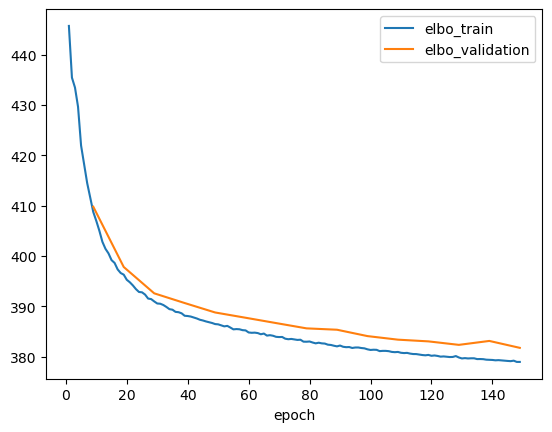

In [22]:
ad_scVI=scVI_workflow(ad.copy(),'gg_250912_shen_heart','/home/gennady/curation-results/cao/scVI/',batch_key='SampleID',
                     n_top_genes=1000,max_epochs=150)

In [23]:
ad_scVI

AnnData object with n_obs × n_vars = 50955 × 27998
    obs: 'SampleID', '_scvi_batch', '_scvi_labels', 'leiden_scVI_02', 'leiden_scVI_04', 'leiden_scVI_06', 'leiden_scVI_08', 'leiden_scVI_10', 'leiden_scVI_12', 'leiden_scVI_14'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'leiden', 'umap'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'distances', 'connectivities'

In [24]:
ad=sc.read_h5ad('/home/gennady/curation-results/cao/scVI/gg_250912_shen_heart.h5ad.gz')

In [25]:
ad

AnnData object with n_obs × n_vars = 50955 × 27998
    obs: 'SampleID', '_scvi_batch', '_scvi_labels', 'leiden_scVI_02', 'leiden_scVI_04', 'leiden_scVI_06', 'leiden_scVI_08', 'leiden_scVI_10', 'leiden_scVI_12', 'leiden_scVI_14'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [26]:

ad.raw=ad.copy()
sc.pp.log1p(ad)

In [111]:
sc.tl.rank_genes_groups(ad, groupby='leiden_scVI_02', groups='all',reference='rest',use_raw=False,method='t-test')

In [119]:
de=sc.get.rank_genes_groups_df(ad,'13')
de.set_index('names',inplace=True)

/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


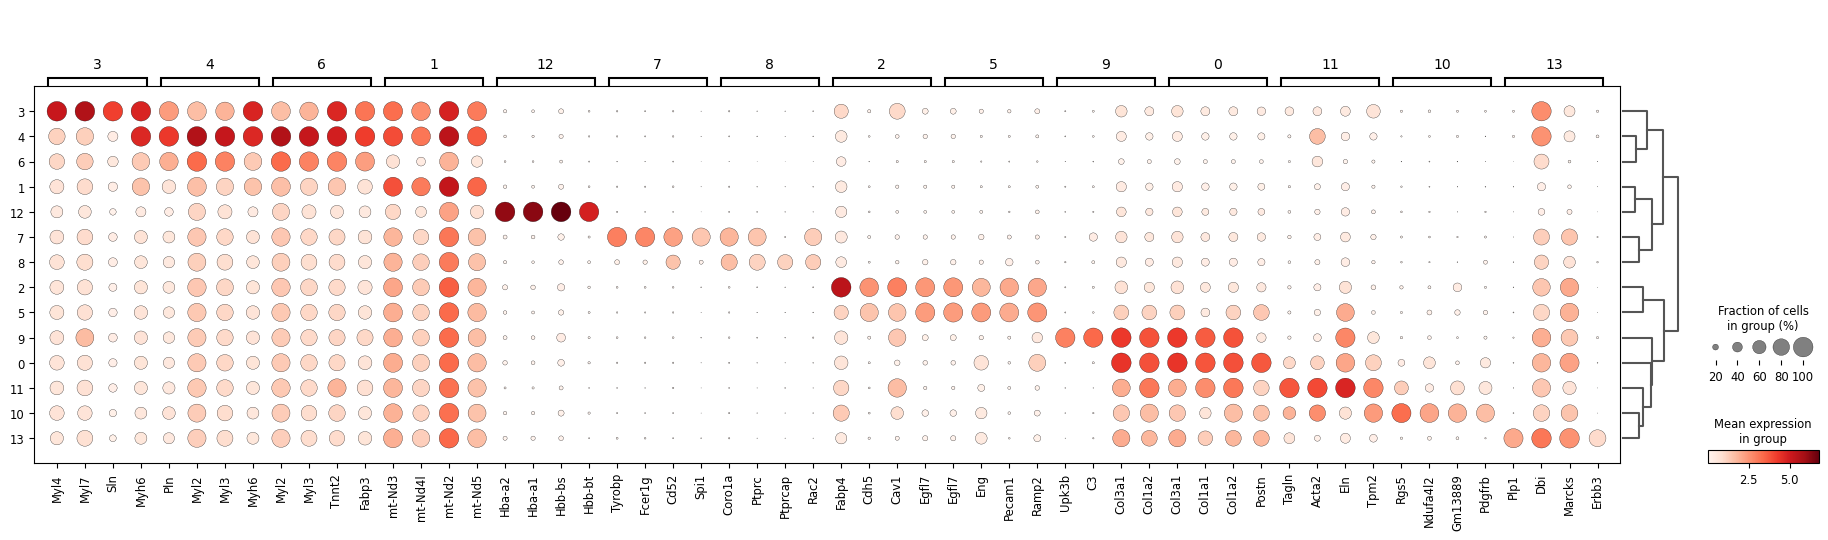

In [120]:
sc.tl.dendrogram(ad,groupby='leiden_scVI_02',use_rep='X_scVI')
sc.pl.rank_genes_groups_dotplot(ad, n_genes=4,use_raw=False)


In [121]:
de.loc[['Plp1','Mpz','Scn7a']]

,scores,logfoldchanges,pvals,pvals_adj
names,,,,
Plp1,28.172789,8.701961,3.109771e-56,7.225507e-55
Mpz,6.973708,9.864156,1.547191e-10,1.101965e-09
Scn7a,10.591818,4.349815,3.859145e-19,4.063496e-18


In [122]:
de.loc[['Xist']]

,scores,logfoldchanges,pvals,pvals_adj
names,,,,
Xist,0.946104,0.17869,0.345894,0.576655


/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


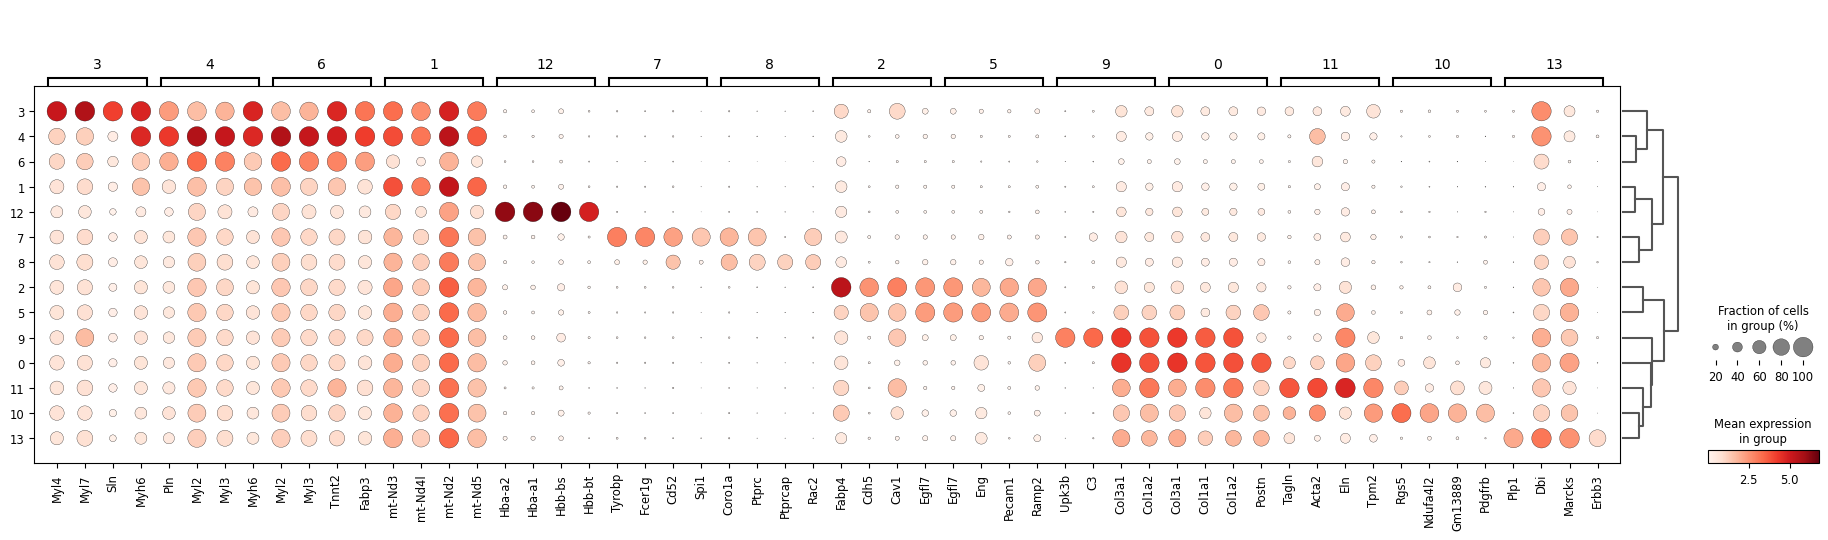

In [123]:
sc.tl.dendrogram(ad,groupby='leiden_scVI_02',use_rep='X_scVI')
sc.pl.rank_genes_groups_dotplot(ad, n_genes=4,use_raw=False)


In [124]:
de=sc.get.rank_genes_groups_df(ad,'6')
de.set_index('names',inplace=True)

In [129]:
de.loc[['Xist','Malat1','Ryr2','Myl2','Myh7','Myh2','Myl3','Tnnt2']]

,scores,logfoldchanges,pvals,pvals_adj
names,,,,
Xist,-158.595886,-5.653269,0.000000e+00,0.000000e+00
Malat1,-142.226120,-4.399996,0.000000e+00,0.000000e+00
Ryr2,-46.421173,-1.995463,0.000000e+00,0.000000e+00
Myl2,53.231510,2.424521,0.000000e+00,0.000000e+00
Myh7,9.961778,0.620279,5.725966e-23,1.154263e-22
Myh2,-4.473009,-18.119091,7.730088e-06,1.284891e-05
Myl3,51.695461,2.258341,0.000000e+00,0.000000e+00
Tnnt2,40.353615,1.591984,1.384103e-280,5.682961e-280


/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


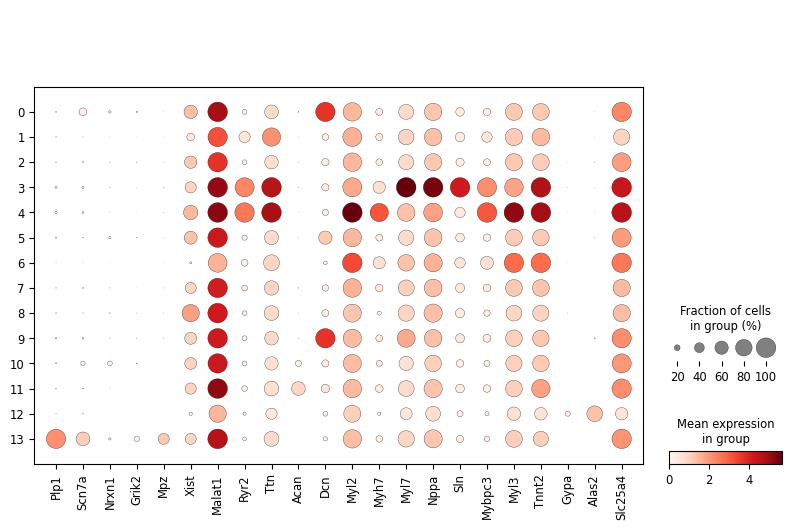

In [130]:
sc.pl.dotplot(ad[ad.obs['SampleID'].isin(['GSM7336852_Day1', 'GSM7336853_Day2', 'GSM7336854_Day4'])],
              groupby='leiden_scVI_02',var_names=['Plp1','Scn7a','Nrxn1','Grik2','Mpz','Xist','Malat1','Ryr2','Ttn','Acan','Dcn',
                                                 'Myl2','Myh7','Myl7','Nppa','Sln','Mybpc3','Myl3','Tnnt2','Gypa','Alas2',
                                                 'Slc25a4'],use_raw=False)

In [131]:
ad.obs['total_UMIs']=ad.X.sum(1)
ad.obs['log_total_UMIs'] = np.log10(ad.obs['total_UMIs'])

/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


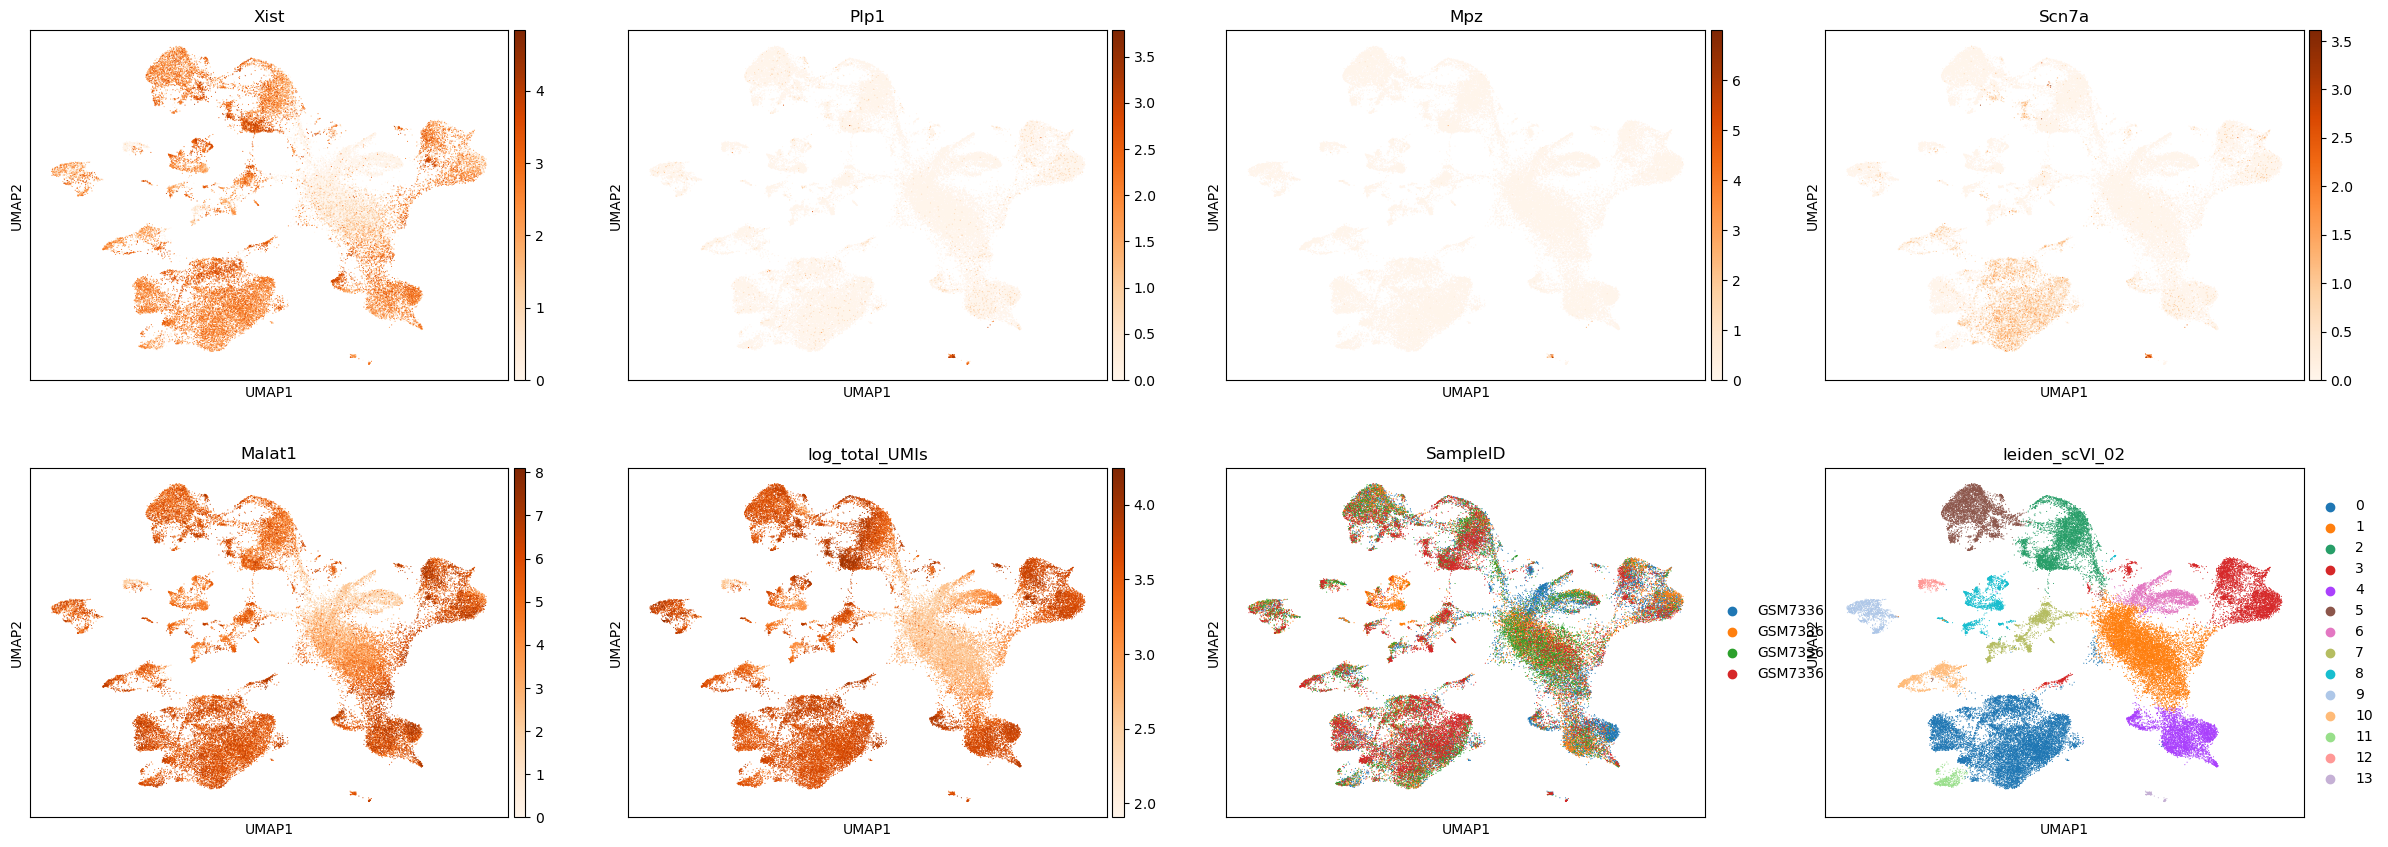

In [133]:
sc.pl.umap(ad,color=['Xist','Plp1','Mpz','Scn7a','Malat1','log_total_UMIs','SampleID','leiden_scVI_02'],use_raw=False, cmap='Oranges')

In [134]:
(ad.obs['leiden_scVI_02']=='13').sum()

127

In [34]:
psbulk = dc.get_pseudobulk(ad,sample_col='SampleID',groups_col='leiden_scVI_02',use_raw=True,mode="sum",min_cells=0,min_counts=0)

In [35]:
psbulk[psbulk.obs['leiden_scVI_02']=='13','Xist'].X.toarray().squeeze().astype(int)

array([ 17, 108, 143, 430])

In [100]:
(psbulk[psbulk.obs['leiden_scVI_02']=='13','Xist'].X.toarray().squeeze().astype(int)/
     psbulk[psbulk.obs['leiden_scVI_02']=='13'].obs['psbulk_n_cells'].values).round(2)

array([0.57, 6.35, 6.5 , 7.41])

In [36]:
psbulk_glob = dc.get_pseudobulk(ad,sample_col='SampleID',groups_col=None,use_raw=True,mode="sum",min_cells=0,min_counts=0)

In [88]:
print(psbulk_glob.obs['SampleID'].values)

['GSM7336852_Day1' 'GSM7336853_Day2' 'GSM7336854_Day4' 'GSM7336855_Day6']


In [37]:
psbulk_glob[:,['Ddx3y','Kdm5d','Uty','Xist']].X.toarray().squeeze().astype(int)

array([[  4727,   1198,   1601,  43841],
       [   967,    256,    288,  79850],
       [  3191,    558,    582,  53940],
       [     2,      4,      1, 148583]])

In [97]:
(psbulk_glob[:,['Ddx3y','Kdm5d','Uty','Xist']].X.toarray().squeeze().astype(int)/psbulk_glob.obs['psbulk_n_cells'].values).round(2)

array([[ 0.32,  0.09,  0.14,  3.49],
       [ 0.07,  0.02,  0.03,  6.36],
       [ 0.22,  0.04,  0.05,  4.29],
       [ 0.  ,  0.  ,  0.  , 11.83]])

In [38]:
print(psbulk_glob[:,['Ddx3y','Kdm5d','Uty','Xist']].X.toarray().squeeze().astype(int).min(0))
print(psbulk_glob[:,['Ddx3y','Kdm5d','Uty','Xist']].X.toarray().squeeze().astype(int).max(0))

[    2     4     1 43841]
[  4727   1198   1601 148583]


In [41]:
psbulk.obs.drop(columns='_scvi_batch',inplace=True)
psbulk_glob.obs.drop(columns='_scvi_batch',inplace=True)
psbulk.obs.drop(columns='_scvi_labels',inplace=True)
psbulk_glob.obs.drop(columns='_scvi_labels',inplace=True)

In [89]:
psbulk.write_h5ad('/home/gennady/curation-results/cao/scVI/gg_250912_shen_heart_l02_psbulk.h5ad.gz',compression='gzip')
psbulk_glob.write_h5ad('/home/gennady/curation-results/cao/scVI/gg_250912_shen_heart_l02_globpsbulk.h5ad.gz',compression='gzip')
